In [16]:
from one_trial_pipeline import *

walking_dirs = os.listdir('walking')
running_dirs = os.listdir('running')

In [17]:
walking_dirs.remove('Walking09')

In [18]:
walking_dirs

['Walking02', 'Walking03', 'Walking04', 'Walking05', 'Walking11']

In [19]:
# ensure correct individual name
root = 'c:\\Users\\ebuly\\OneDrive\\Documents\\WORK\\JRF_GaitAnalysis'
cwd = os.getcwd()
tmp = cwd.split('\\')[len(root.split('\\')):]
ind = 'P' + tmp[0][1:]
ind

'P05'

# Walking

In [20]:
individual_tag = ind

model_name =  f'scaled_model_{individual_tag}_joints.osim'
model_folder = os.path.join('../', 'model_update', '3a_osim_markers') 

# model_name =  f'{individual_tag}_tps_fibres_skin_wrp_updated.osim'
# model_folder = os.path.join('../', 'model_update', '4_tps-bones-muscles-updated') 

tempalte_dir = os.path.abspath(os.path.join('../', 'templates'))
actuator_file = os.path.join(tempalte_dir, 'final_actuators.xml')
first_foot_file_name = 'steps.txt'

# create results dir
results_dir = f'results_{model_name[:-5]}'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

# create walking dir
walking_results = os.path.abspath(os.path.join(os.path.join(results_dir, 'walking')))
if not os.path.exists(walking_results):
    os.mkdir(walking_results)



## main

In [21]:

for folder in walking_dirs:
    print(folder)
    input_dir = os.path.abspath(os.path.join('../', 'Python', 'walking', folder)) 
    trc_file_name = os.path.join(input_dir, 'task.trc')
    grf_mot_file_name = 'task_grf.mot'
    step_data_file_name =  'df_steps.csv'
    first_foot_file_name = 'steps.txt'

    # create trial output dir
    output_dir = os.path.abspath(os.path.join(walking_results, folder))
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    run_walking = RunAnalysesPipeline(individual_tag,model_name, model_folder,input_dir,
                                    trc_file_name, grf_mot_file_name, step_data_file_name,
                                    tempalte_dir, actuator_file, output_dir = output_dir, first_foot_file_name = first_foot_file_name)
    
    # run_walking.basic()
    # run_walking.run_so()
    # run_walking.run_jr()

Walking02
obtain_first_foot started
first_foot r
Walking03
obtain_first_foot started
first_foot r
Walking04
obtain_first_foot started
first_foot r
Walking05
obtain_first_foot started
first_foot r
Walking11
obtain_first_foot started
first_foot r


## muscle moment arm discontinuities

In [22]:
ma_time_series_files = ['hip_rot_muscle_moment_arms.csv',
                        'hip_flex_muscle_moment_arms.csv',
                        'hip_add_muscle_moment_arms.csv',
                        'knee_flex_muscle_moment_arms.csv',
                        'ankle_flex_muscle_moment_arms.csv']

for folder in walking_dirs:
    path_to_time_series = os.path.join(results_dir, 'walking', folder,'muscle_moment_arms')
    write_json_to = path_to_time_series
    
    for table in ma_time_series_files:
        muscle_arm_discontinuity(path_to_time_series, table, write_json_to, threshold = 0.005)

## step

In [23]:
import logging
from datetime import datetime
# note date and time
date_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
# activate logger
logger = logging.getLogger(__name__)
logging.basicConfig(filename=f'{date_time}.log', format='%(asctime)s %(message)s', encoding='utf-8', level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True

def run_analyses (right_time_tuples, left_time_tuples, output_dir):
    #moment arms
    logger.info(f' Moment arms')  
    ma_time_series_files = ['hip_rot_muscle_moment_arms.csv',
                            'hip_flex_muscle_moment_arms.csv',
                            'hip_add_muscle_moment_arms.csv',
                            'knee_flex_muscle_moment_arms.csv',
                            'ankle_flex_muscle_moment_arms.csv']
    for table in ma_time_series_files:
        path_to_time_series = os.path.join(output_dir, 'muscle_moment_arms', table)
        logger.info(f'Looking in {path_to_time_series}') 
        ma_steps = ResampleAndAverageSteps(path_to_time_series, right_time_tuples=right_time_tuples, left_time_tuples=left_time_tuples)
                
        if not ma_steps.right_df.empty:
            ma_steps.right_df.to_csv(os.path.join(output_dir, f'right_{table}'))
        if not ma_steps.left_df.empty:
            ma_steps.left_df.to_csv(os.path.join(output_dir, f'left_{table}'))


    # IK
    logger.info('extracting steps for ' + 'IK_results.mot')
    path_to_time_series = os.path.join(output_dir, 'IK_results.mot')
    IK_steps = ResampleAndAverageSteps(path_to_time_series, right_time_tuples=right_time_tuples, left_time_tuples=left_time_tuples)

    if not IK_steps.right_df.empty:
        IK_steps.right_df.to_csv(os.path.join(output_dir, 'right_kinem.csv'))
    if not IK_steps.left_df.empty:
        IK_steps.left_df.to_csv(os.path.join(output_dir, 'left_kinem.csv'))

    IK_steps.plot_steps_one_trial(folder + ' IK', output_dir)

    # ID
    logger.info('extracting steps for ' + 'ID_results.mot')
    path_to_time_series = os.path.join(output_dir, 'ID_results.mot')
    ID_steps = ResampleAndAverageSteps(path_to_time_series, right_time_tuples=right_time_tuples, left_time_tuples=left_time_tuples)

    if not ID_steps.right_df.empty:
        ID_steps.right_df.to_csv(os.path.join(output_dir, 'right_dynam.csv'))
    if not ID_steps.left_df.empty:
        ID_steps.left_df.to_csv(os.path.join(output_dir, 'left_dynam.csv'))


    # SO
    logger.info('extracting steps for ' + 'SO_Results/SO_StaticOptimization_activation.sto')
    path_to_time_series = os.path.join(output_dir, 'SO_Results/SO_StaticOptimization_activation.sto')
    SO_steps = ResampleAndAverageSteps(path_to_time_series, right_time_tuples=right_time_tuples, left_time_tuples=left_time_tuples)

    if not SO_steps.right_df.empty:
        SO_steps.right_df.to_csv(os.path.join(output_dir, 'right_SO.csv'))
    if not SO_steps.left_df.empty:
        SO_steps.left_df.to_csv(os.path.join(output_dir, 'left_SO.csv'))

    # JR
    logger.info('extracting steps for ' + 'SO_Results/JR_JointReaction_ReactionLoads.sto')
    path_to_time_series = os.path.join(output_dir, 'SO_Results/JR_JointReaction_ReactionLoads.sto')
    JR_steps = ResampleAndAverageSteps(path_to_time_series, right_time_tuples=right_time_tuples, left_time_tuples=left_time_tuples)

    if not JR_steps.right_df.empty:
        JR_steps.right_df.to_csv(os.path.join(output_dir, 'right_JR.csv'))
    if not JR_steps.left_df.empty:
        JR_steps.left_df.to_csv(os.path.join(output_dir, 'left_JR.csv'))


obtain_first_foot started
first_foot r
obtain_first_foot started
first_foot r
obtain_first_foot started
first_foot r
obtain_first_foot started
first_foot r
obtain_first_foot started
first_foot r


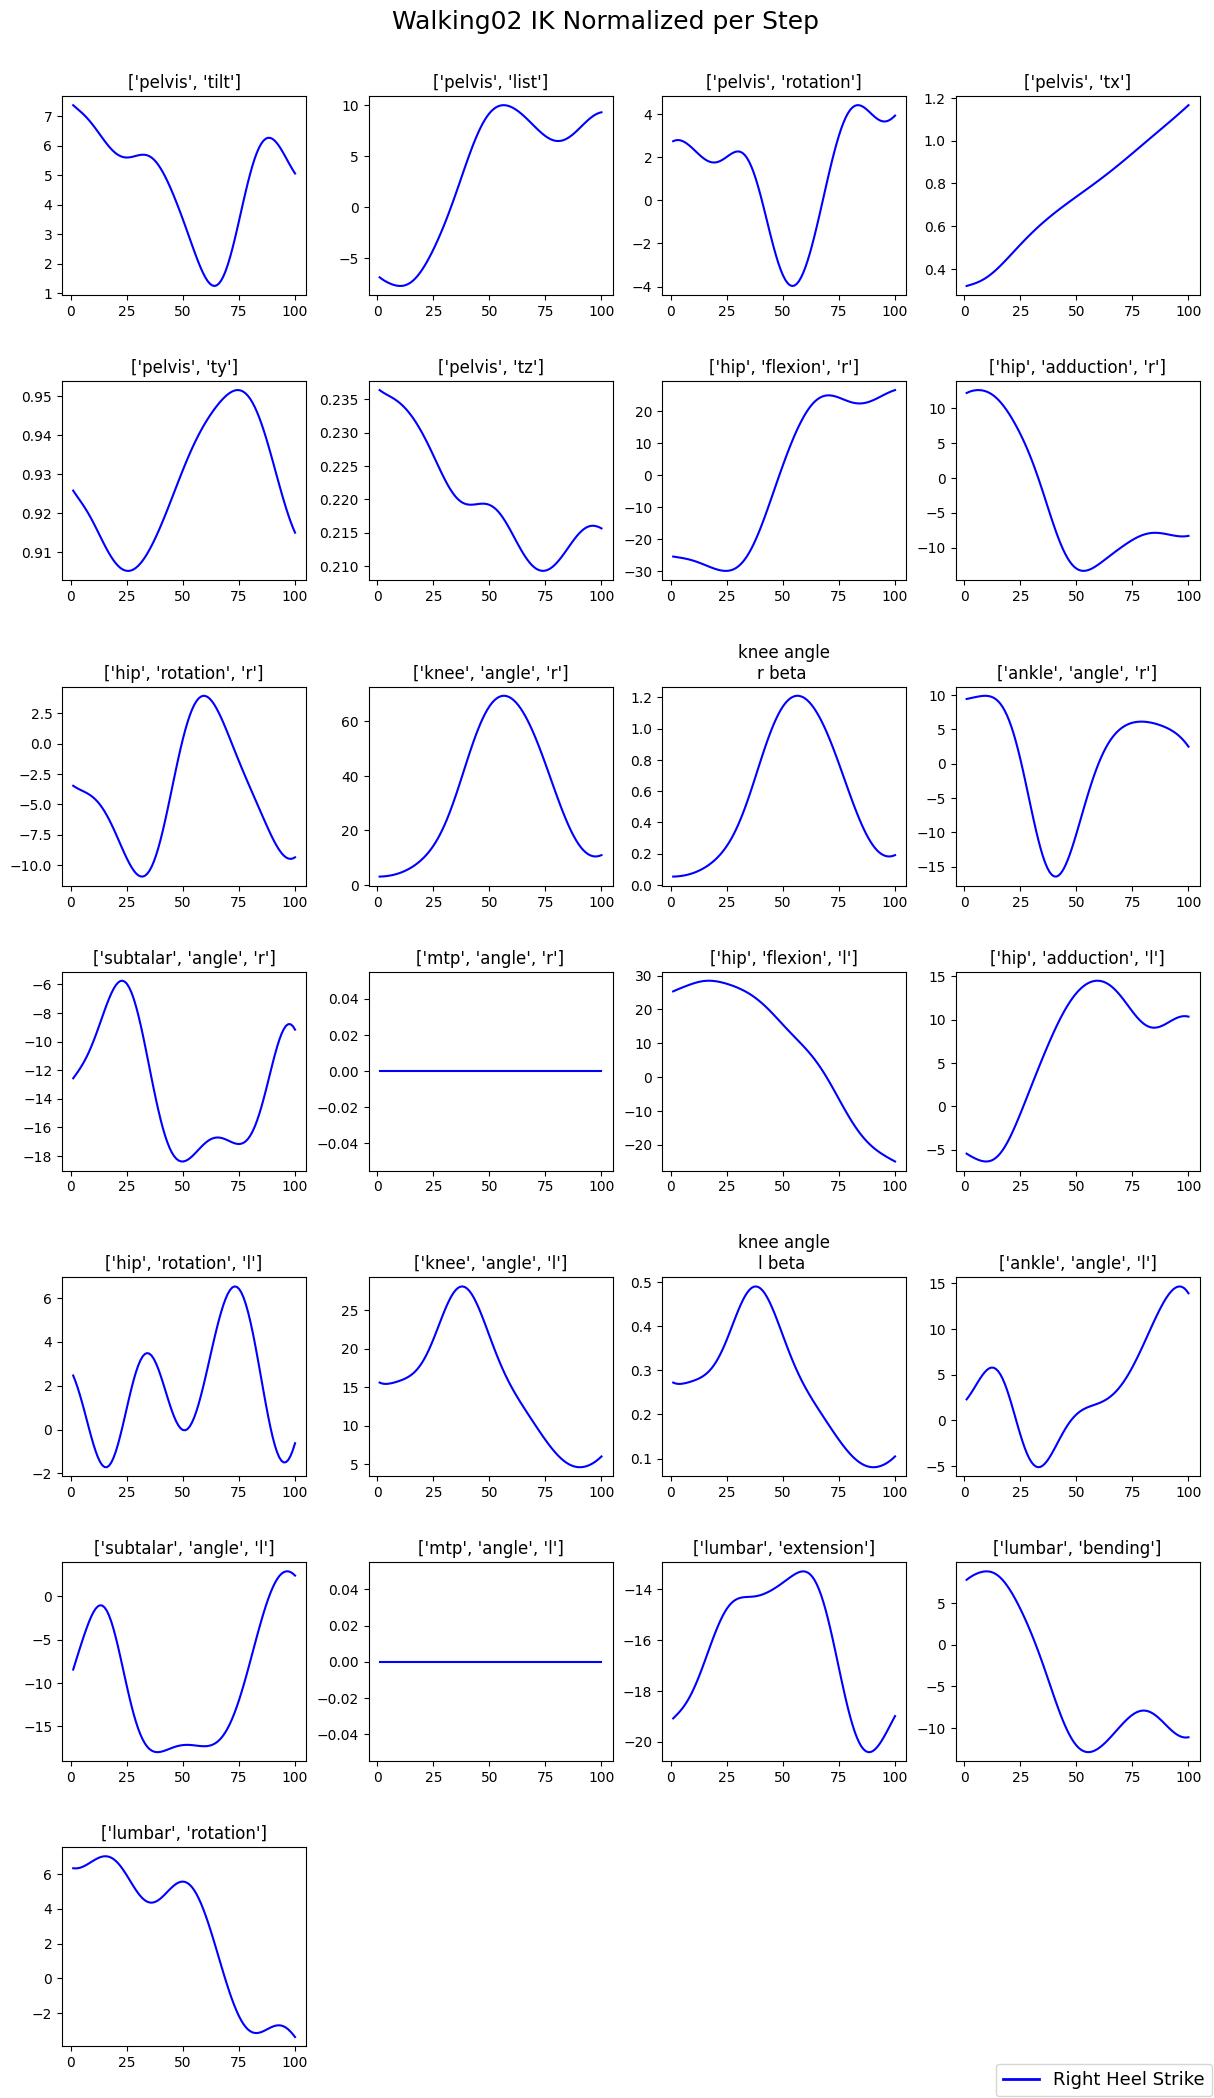

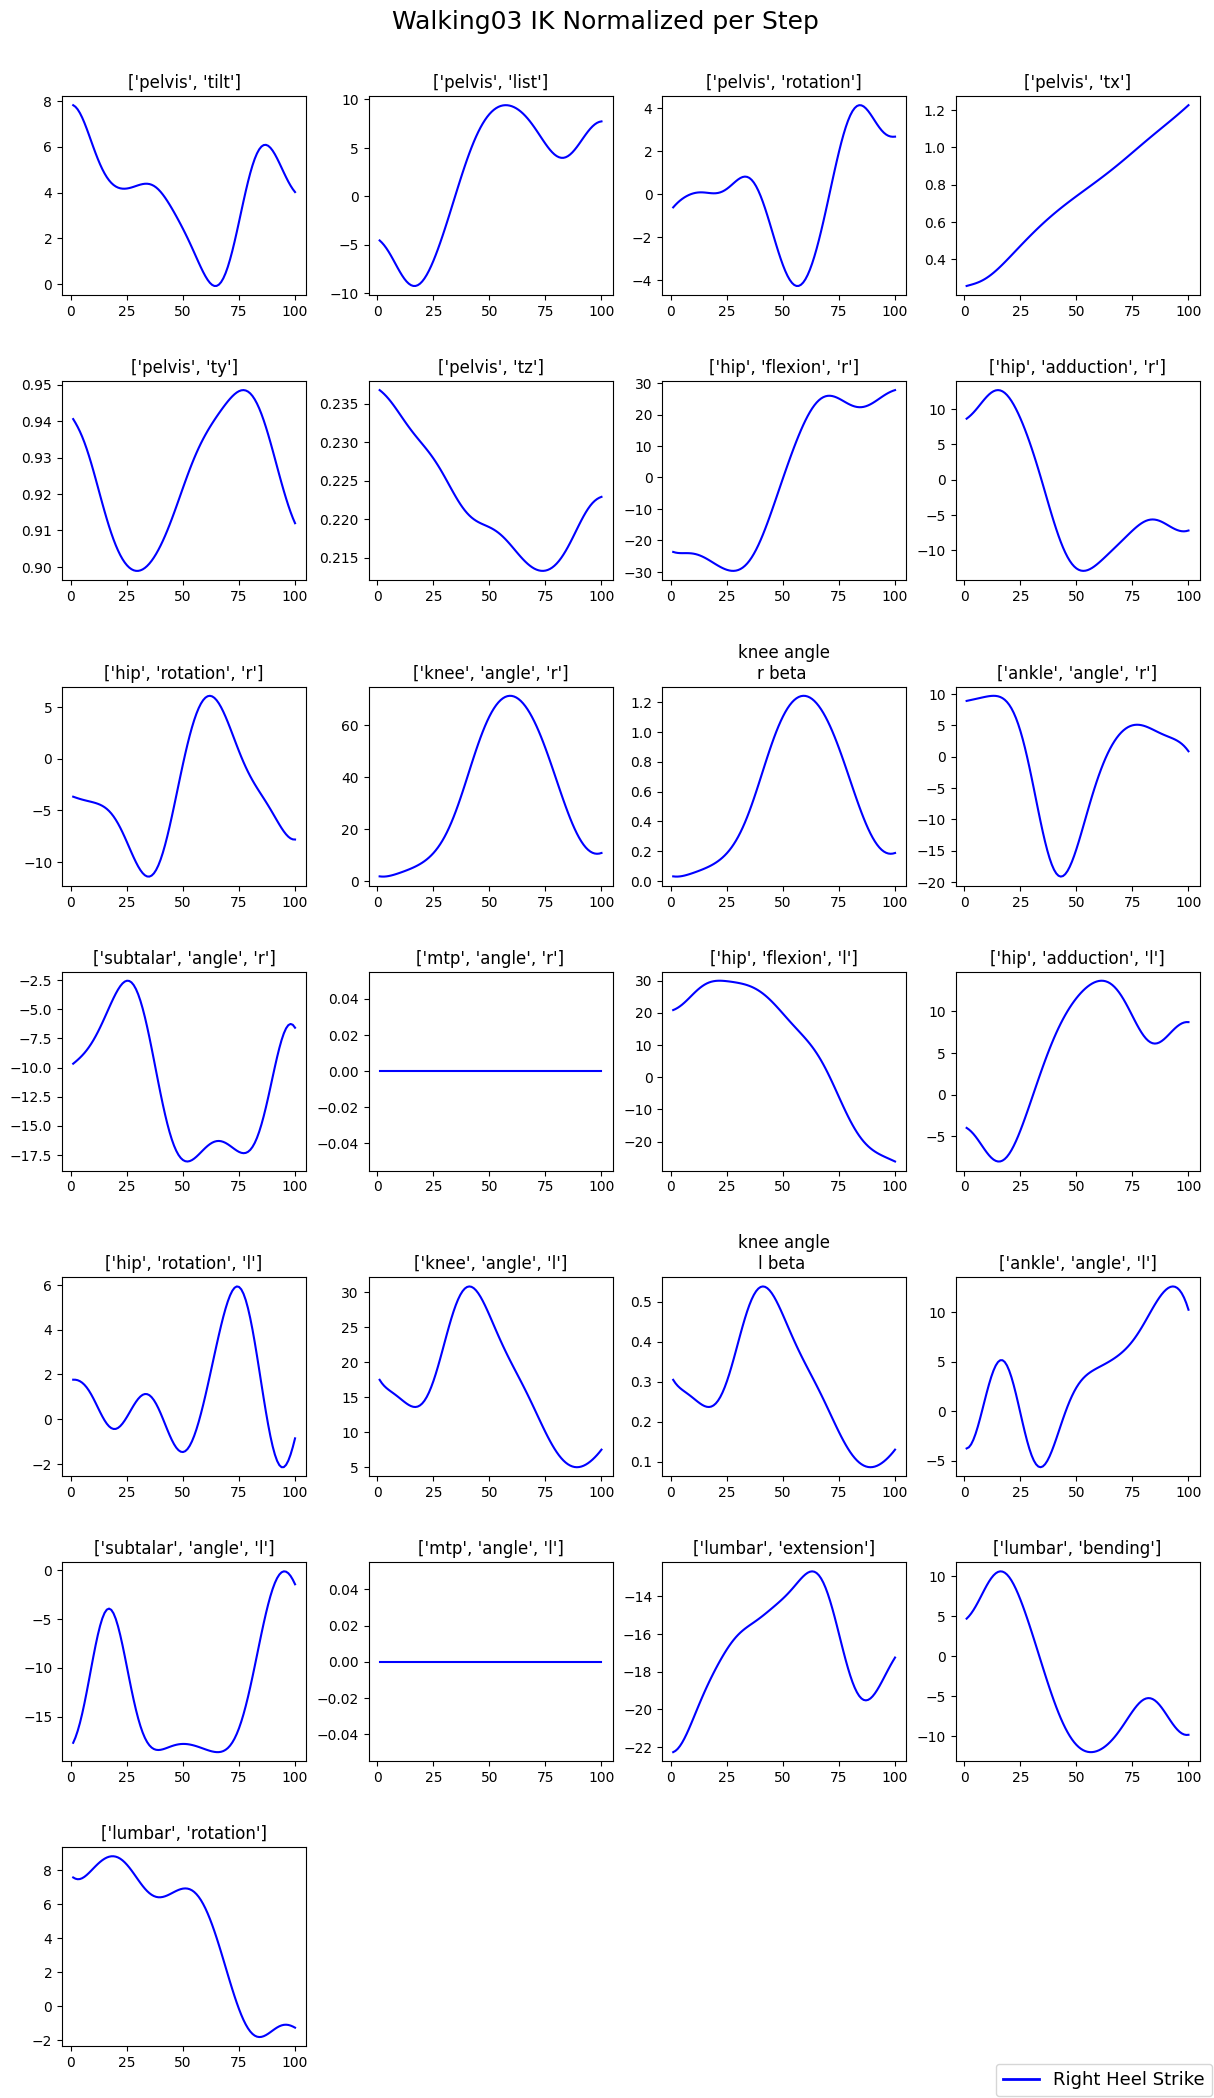

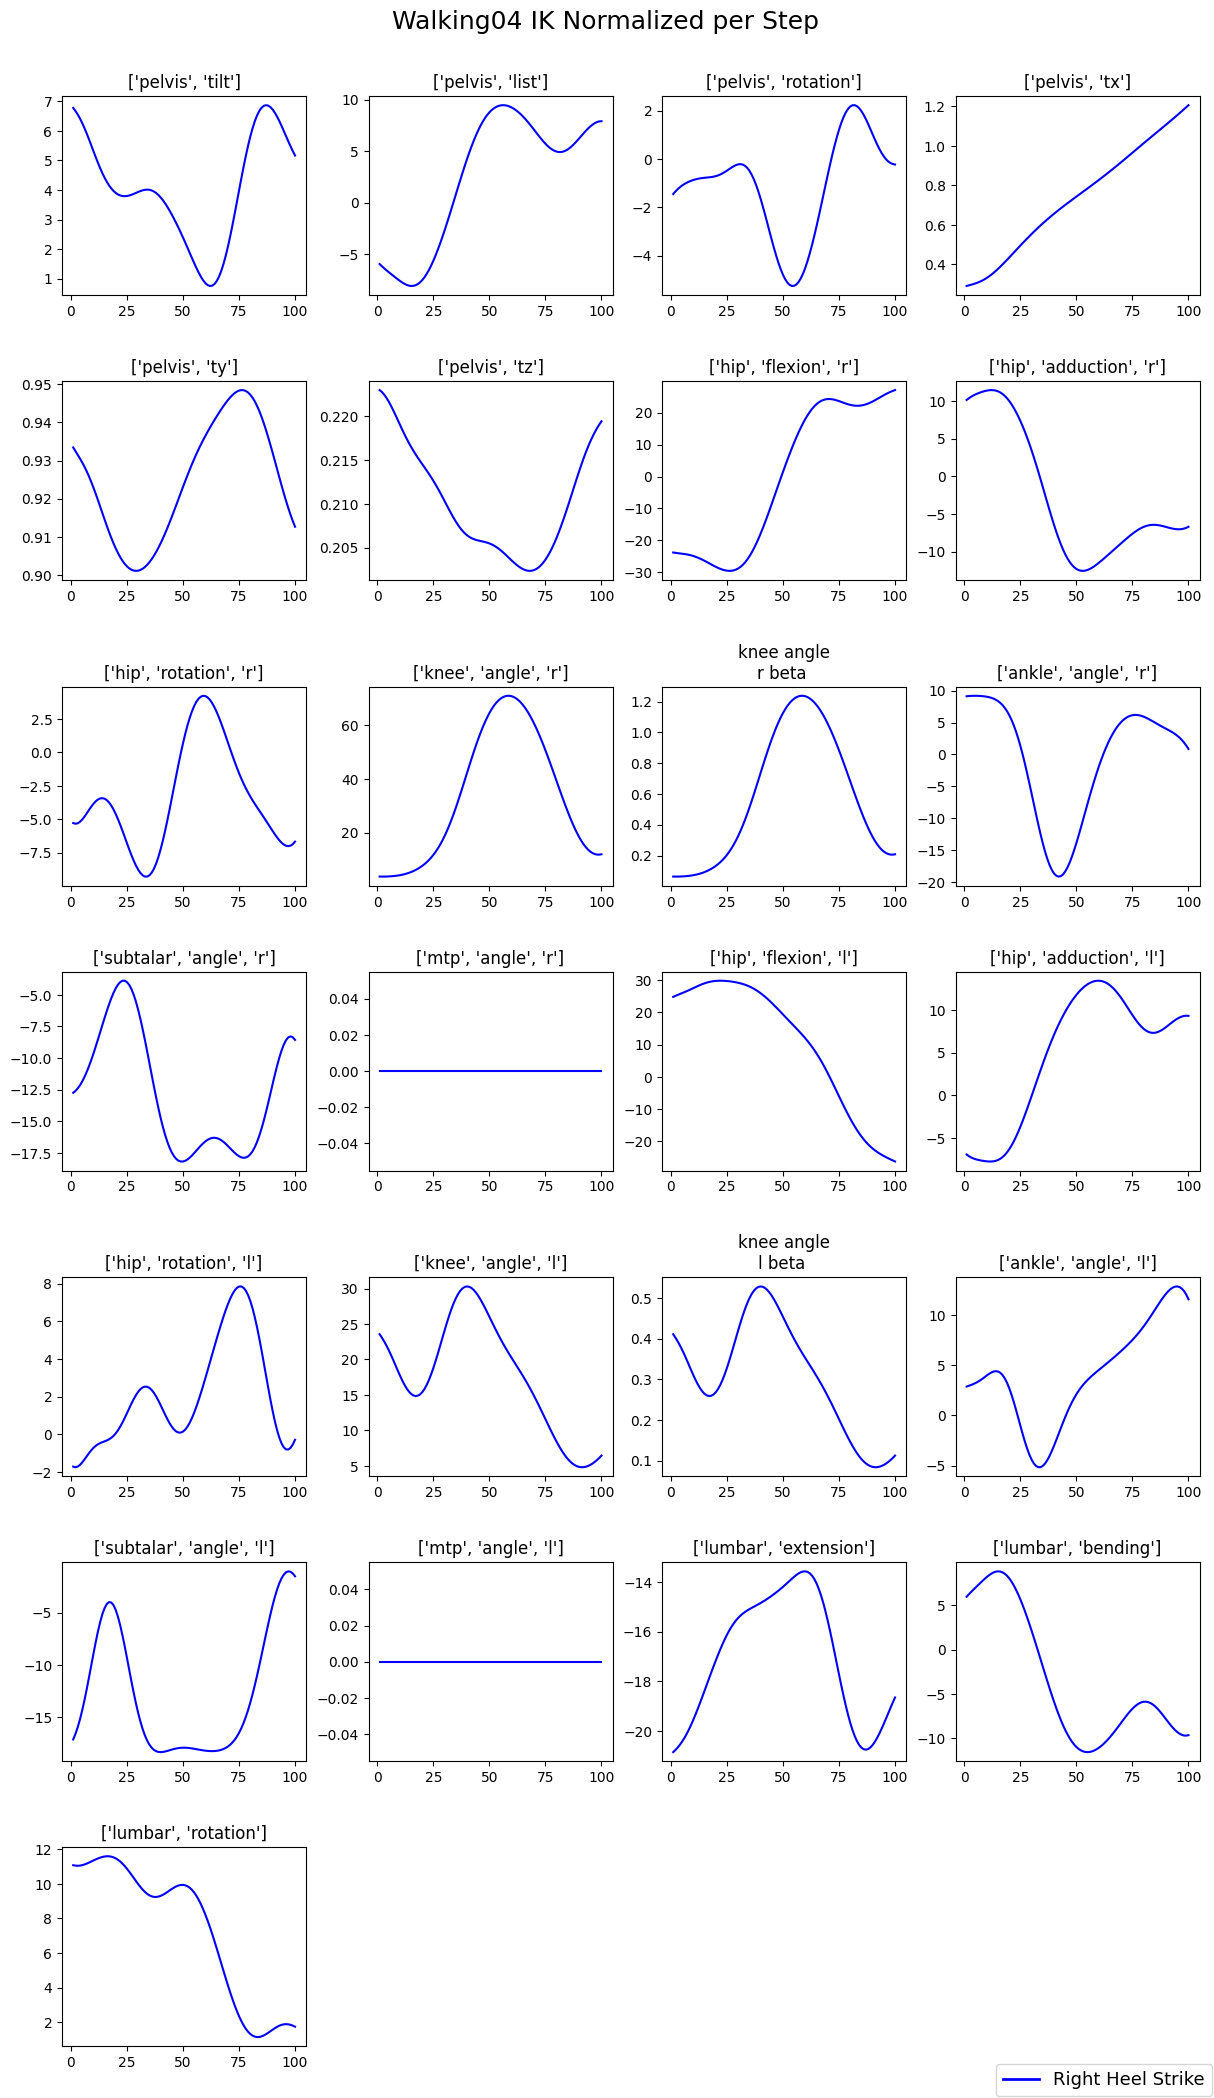

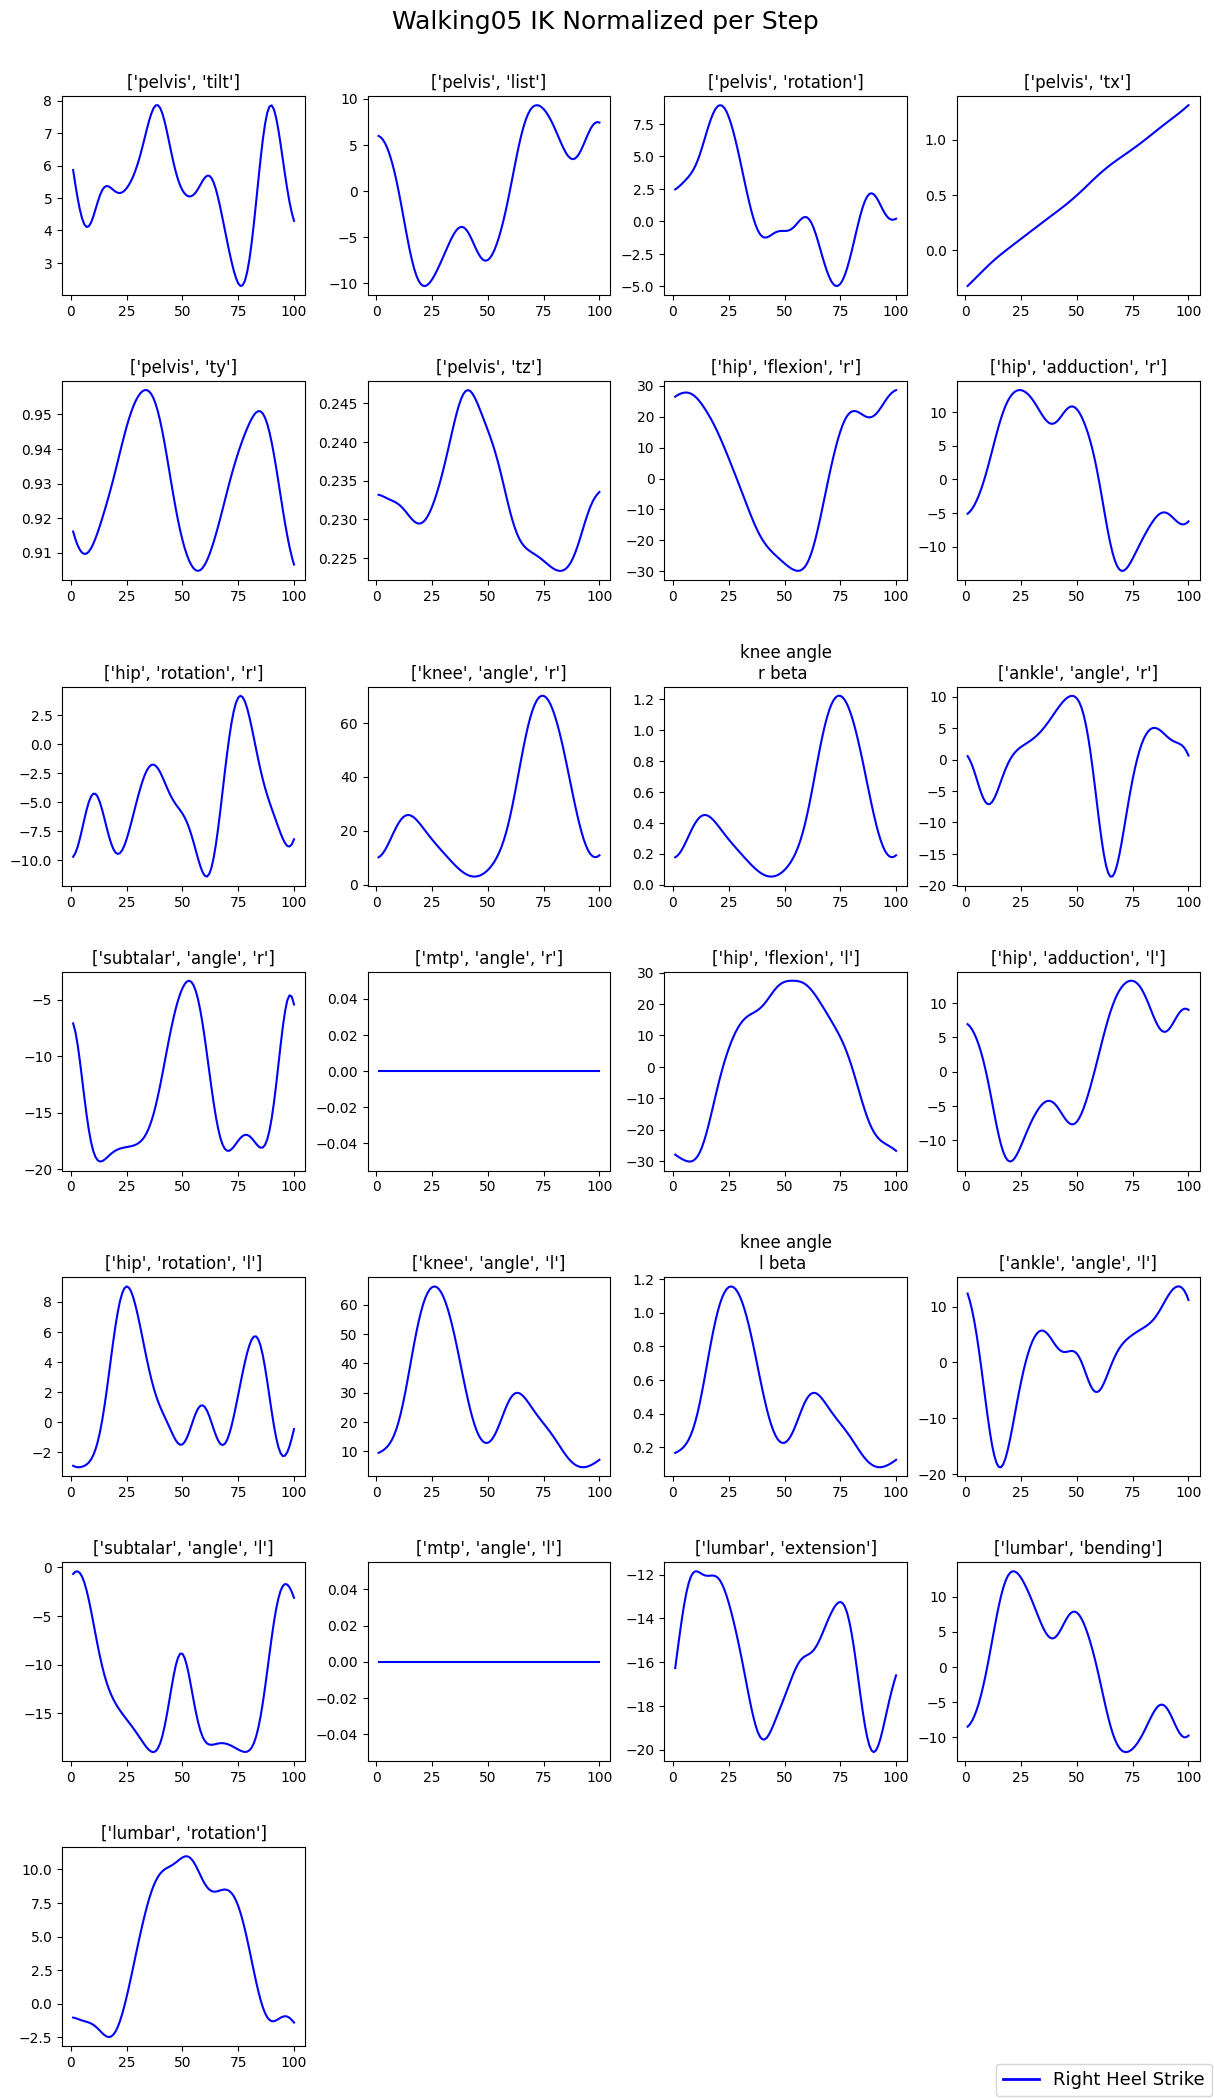

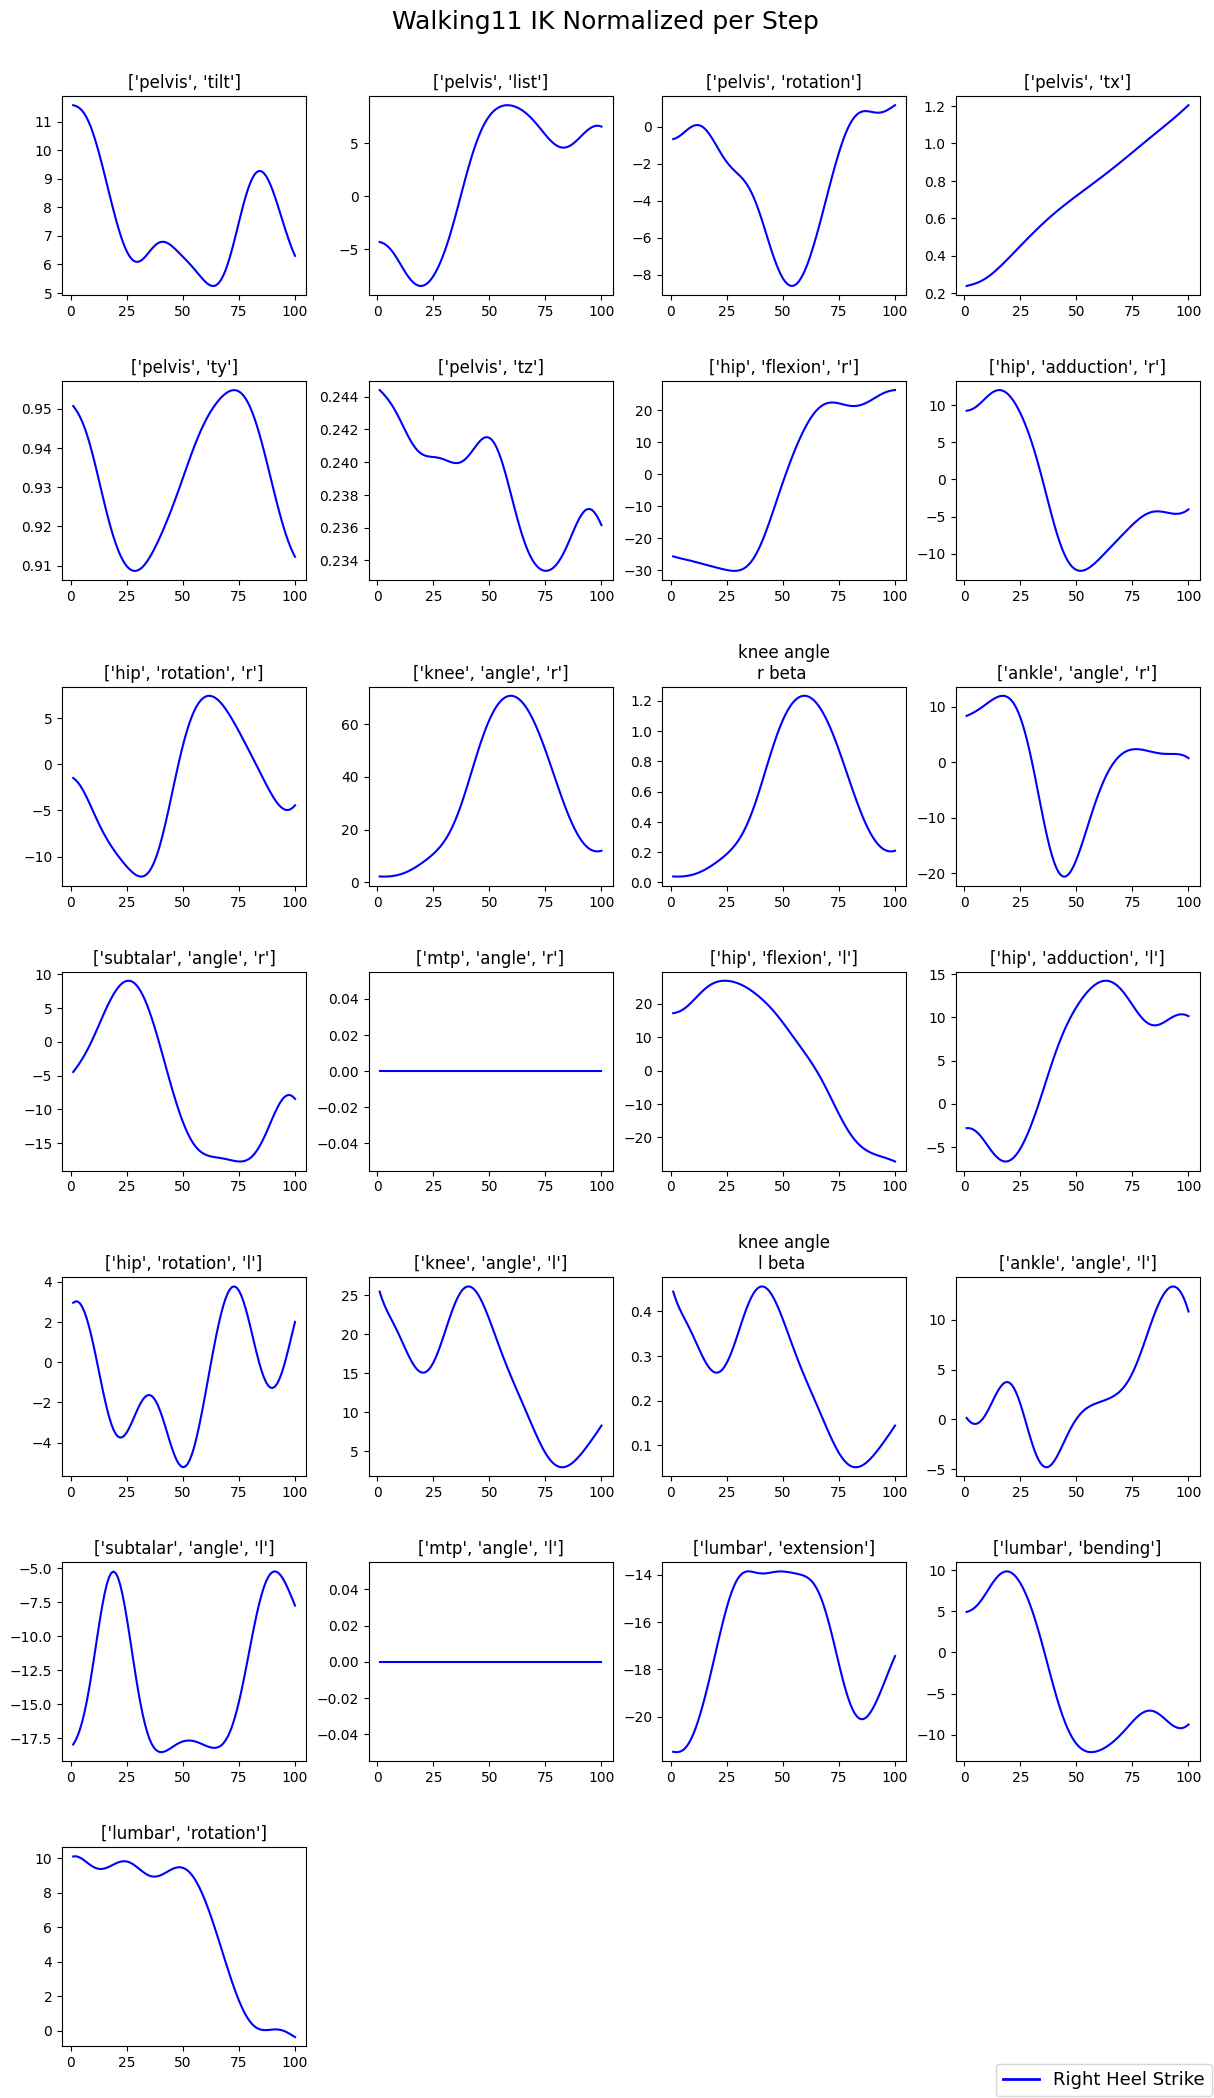

In [24]:
#%%capture out

for folder in walking_dirs:

    input_dir = os.path.abspath(os.path.join('../', 'Python', 'walking', folder))
    output_dir = os.path.join(walking_results, folder)
    path_to_so_results = os.path.join(output_dir,'SO_Results/SO_StaticOptimization_activation.sto')
    path_to_steps_data_file =  os.path.join(input_dir,'df_steps.csv')

    # extract steps
    logger.info('\n' + 'running step extraction for ' + f'{folder}' + '\n')

    extract_steps = OneTrialSteps(path_to_so_results, input_dir, path_to_steps_data_file, first_foot_file_name = first_foot_file_name)

    logger.info('the first foot is '+ extract_steps.first_foot+ '\n')

    right_heel_strikes = extract_steps.def_right_heel_strike()
    left_heel_strikes = extract_steps.def_left_heel_strike()
    extract_steps.full_cycle() 
    
    right_time_tuples = extract_steps.right_cycle
    left_time_tuples = extract_steps.left_cycle
 
    logger.info('right_time_tuples '+ str(len(right_time_tuples))+ '\n')
    logger.info('right_time_tuples '+ str(right_time_tuples)+ '\n')
    logger.info('left_time_tuples '+ str(len(left_time_tuples))+ '\n')
    logger.info('left_time_tuples '+ str(left_time_tuples)+ '\n')


    if right_time_tuples:
        if len(right_time_tuples) > 0:
            right_time_tuples = right_time_tuples
            if left_time_tuples:
                if len(left_time_tuples) > 0:
                    left_time_tuples = left_time_tuples
                    run_analyses(right_time_tuples, left_time_tuples, output_dir)
            else: 
                left_time_tuples == None
                run_analyses(right_time_tuples, left_time_tuples, output_dir)
    else:
        if left_time_tuples:
            if len(left_time_tuples) > 0:
                left_time_tuples = left_time_tuples
                right_time_tuples = None
                run_analyses(right_time_tuples, left_time_tuples, output_dir)
        else:  
            logger.info('no valid step data - skip' '\n')
            pass



## final

In [25]:
walking_dirs = ['Walking05']

folder Walking05 has no valid left_hip_rot_muscle_moment_arms data
folder Walking05 has no valid left_hip_flex_muscle_moment_arms data
folder Walking05 has no valid left_hip_add_muscle_moment_arms data
folder Walking05 has no valid left_knee_flex_muscle_moment_arms data
folder Walking05 has no valid left_ankle_flex_muscle_moment_arms data
folder Walking05 has no valid left_kinem data
folder Walking05 has no valid left_dynam data
folder Walking05 has no valid left_SO data
folder Walking05 has no valid left_JR data


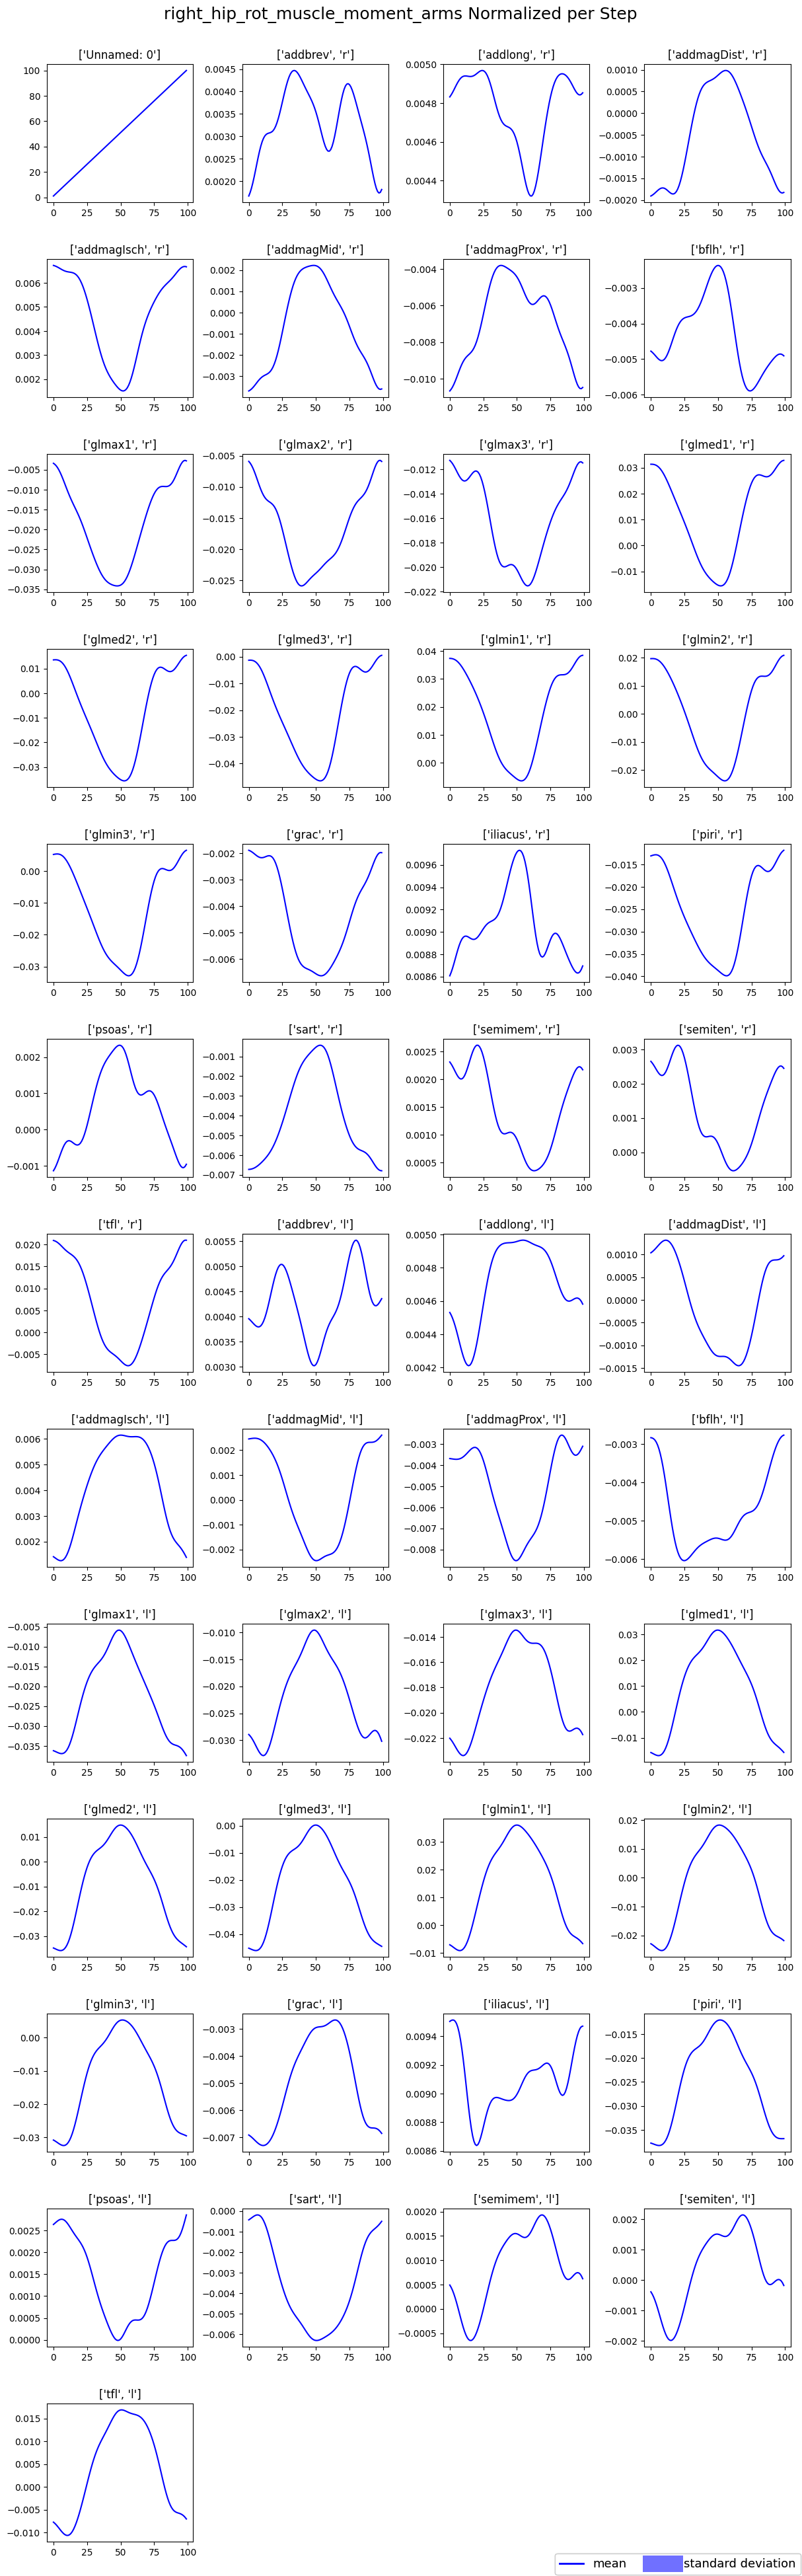

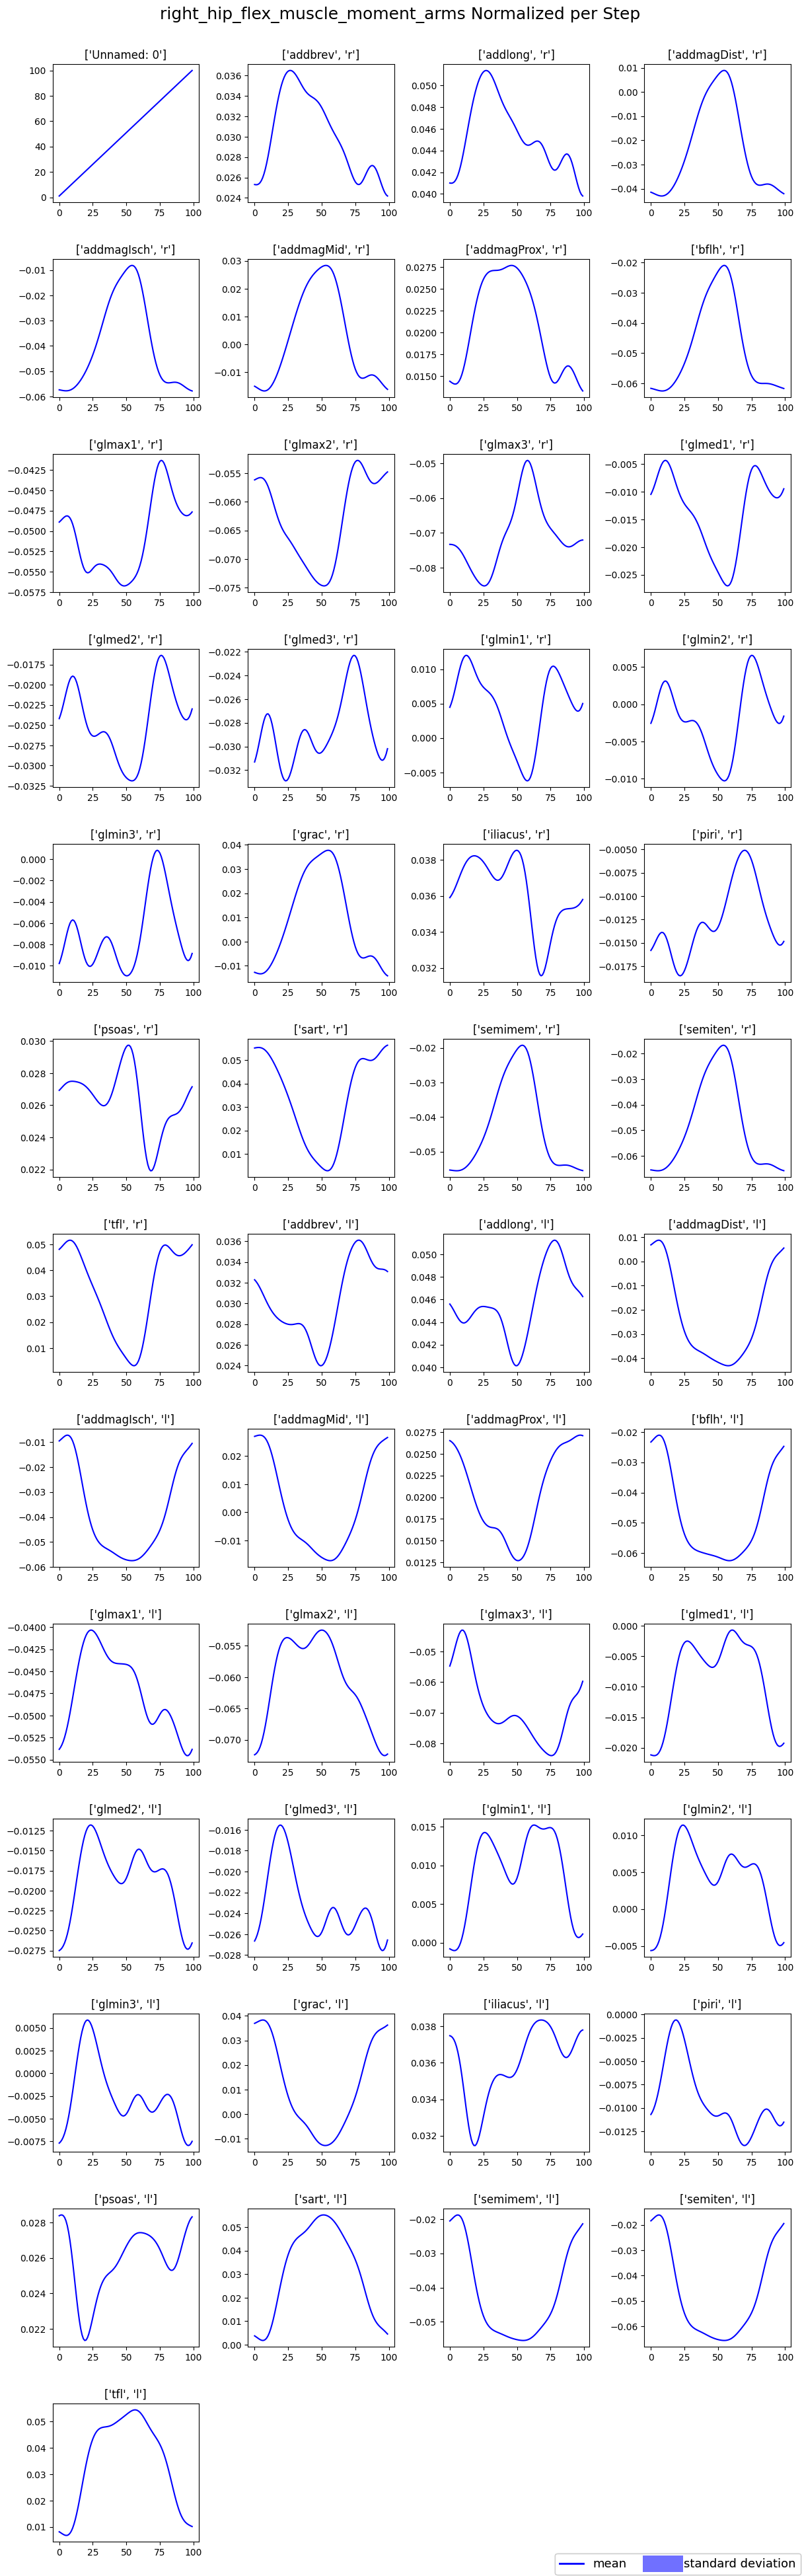

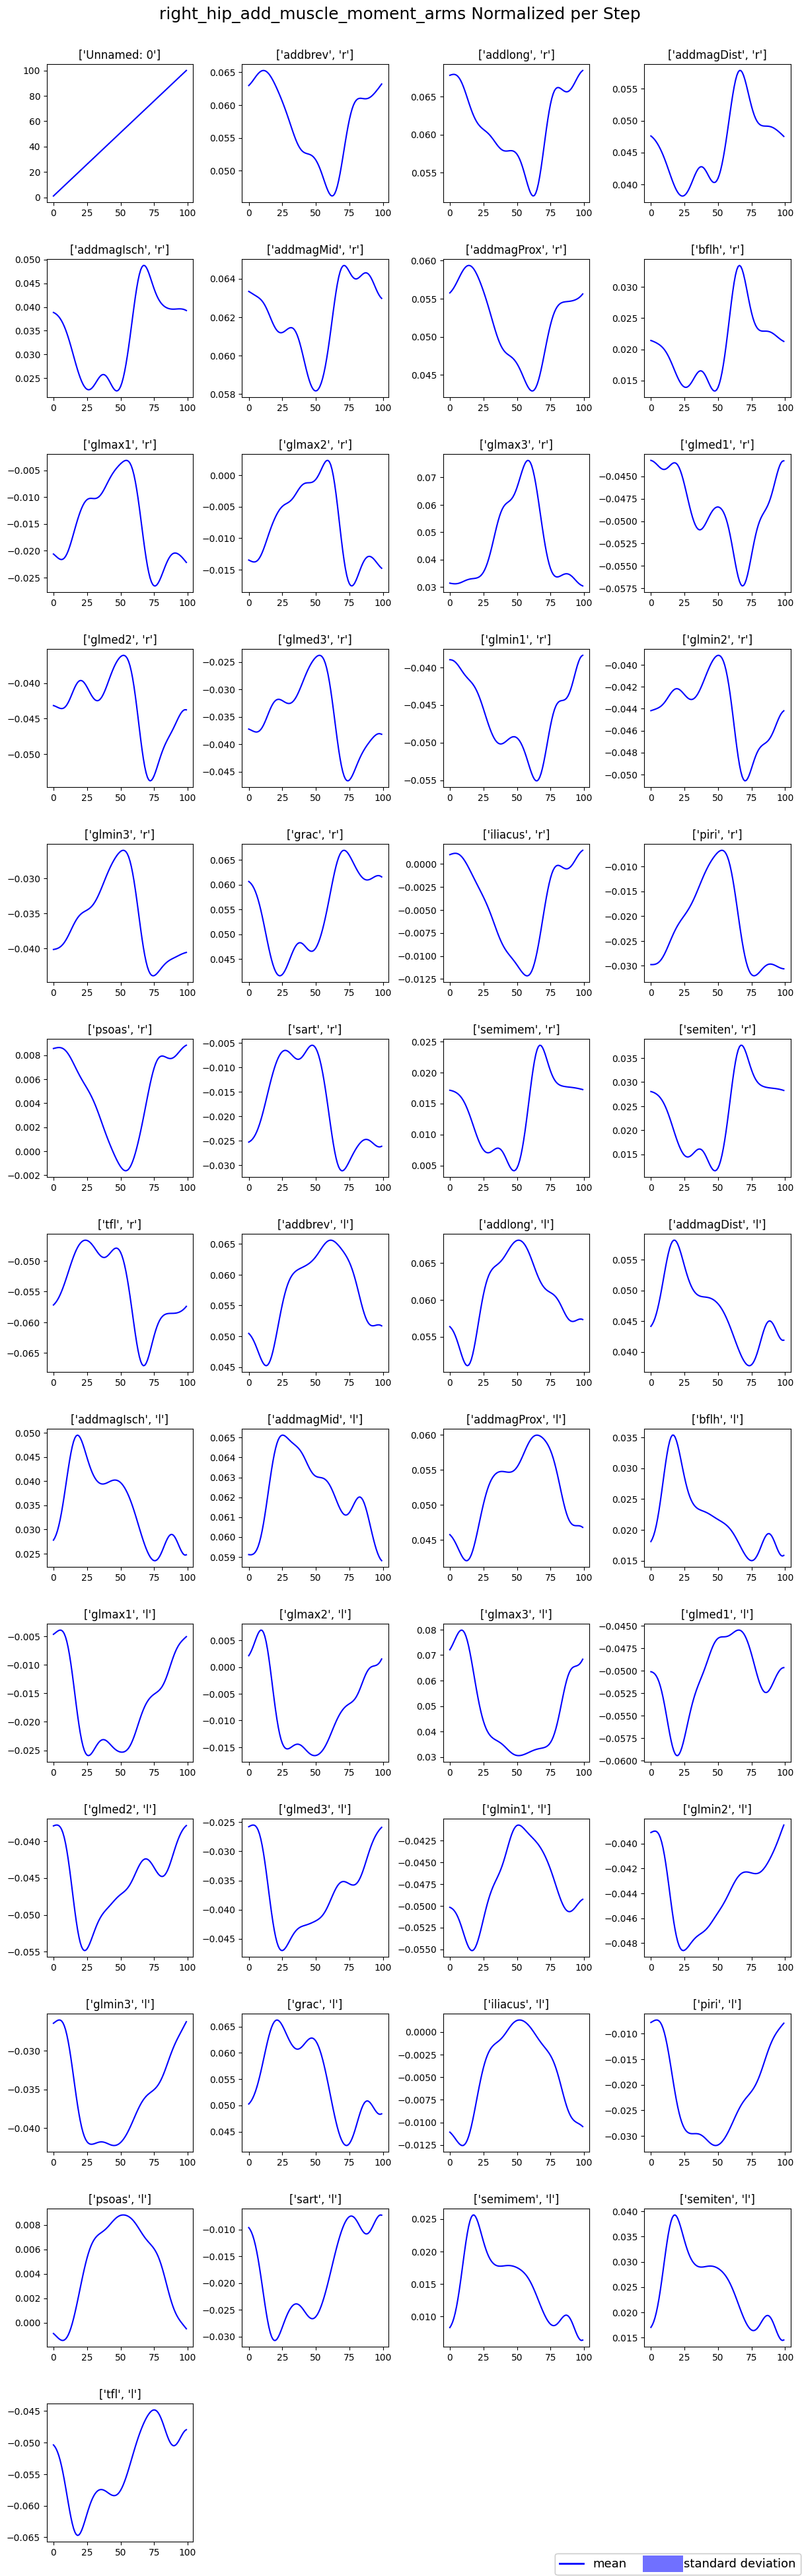

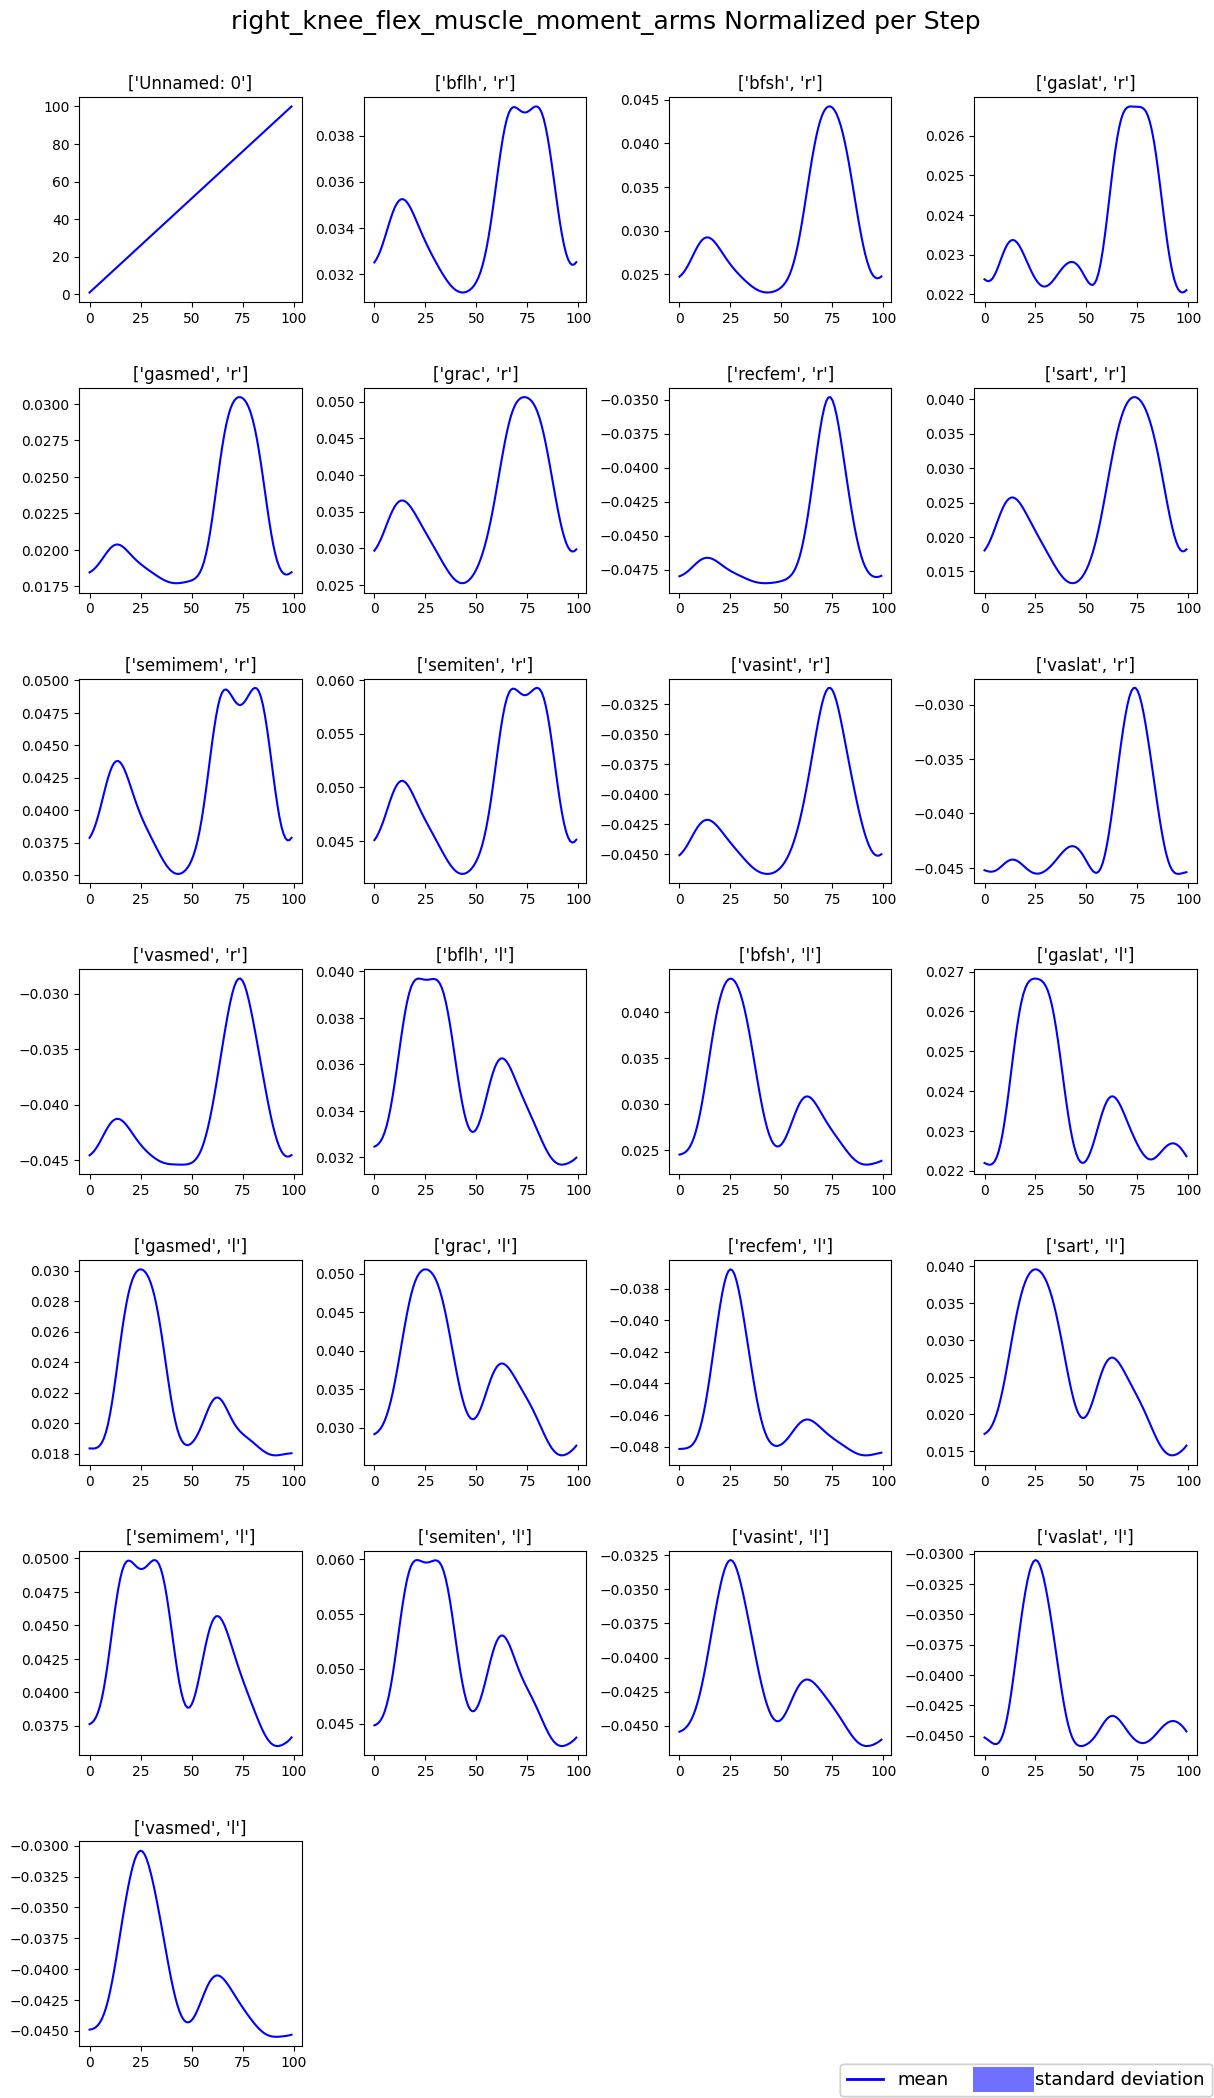

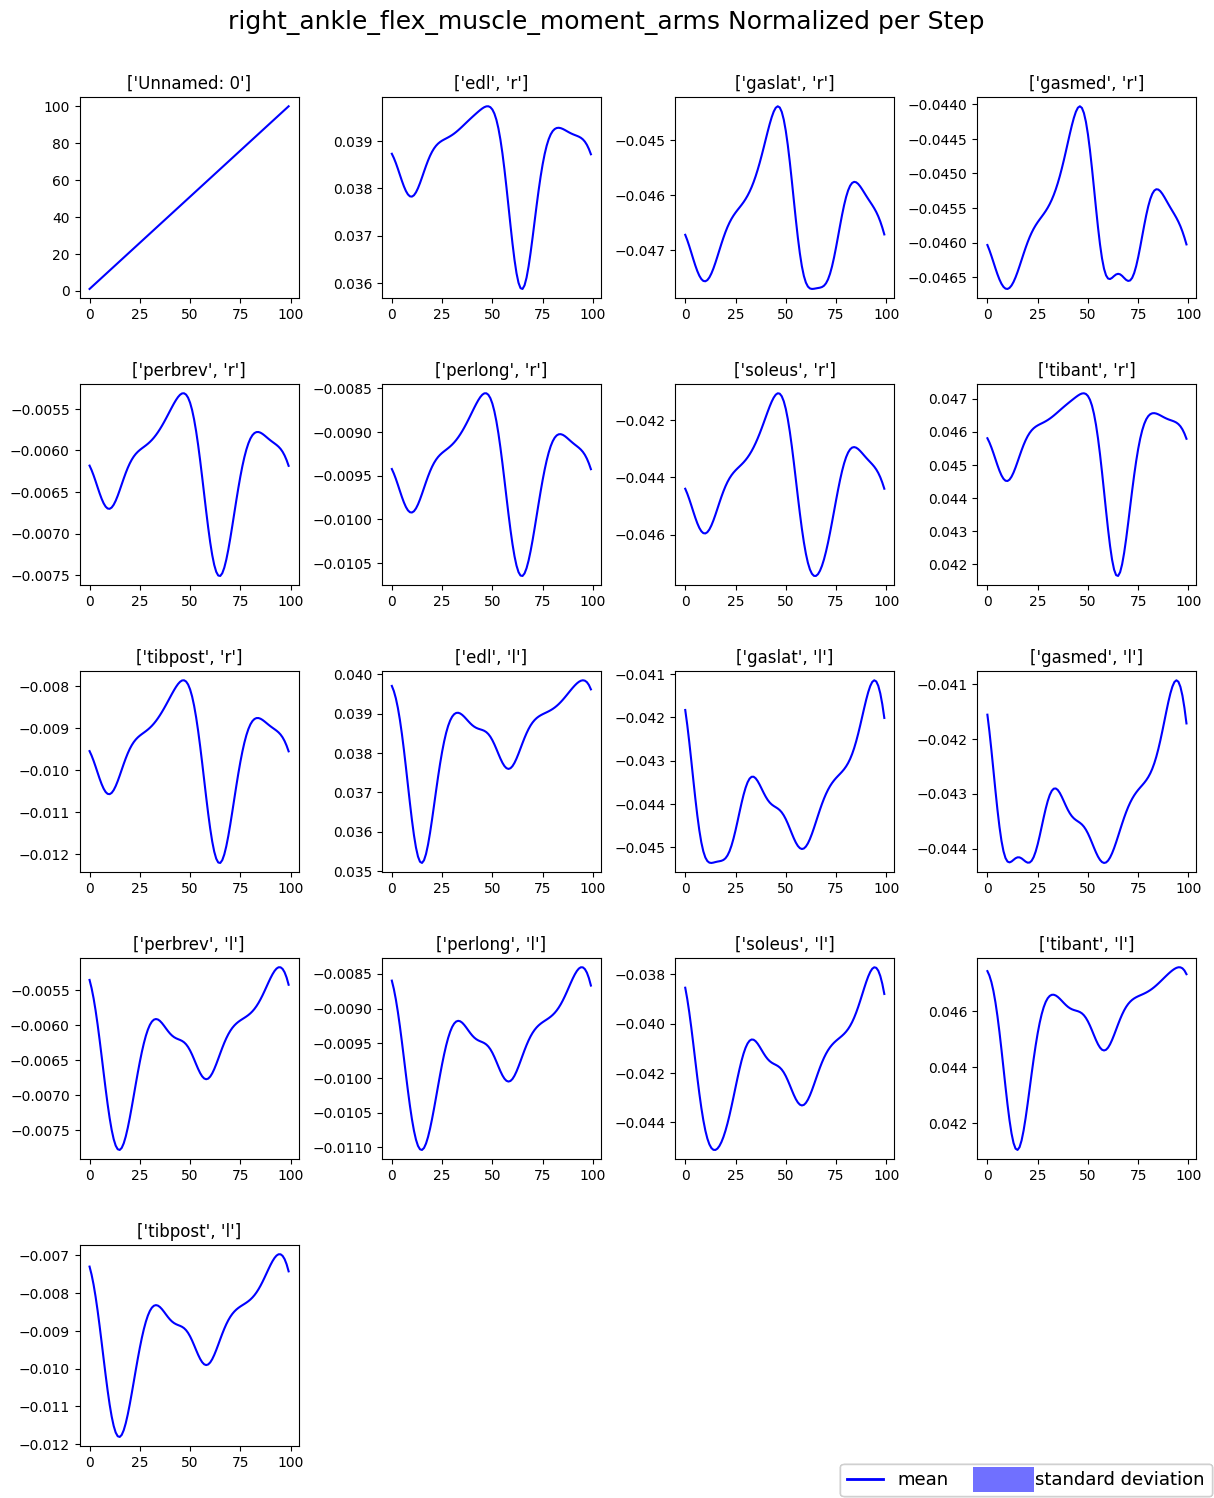

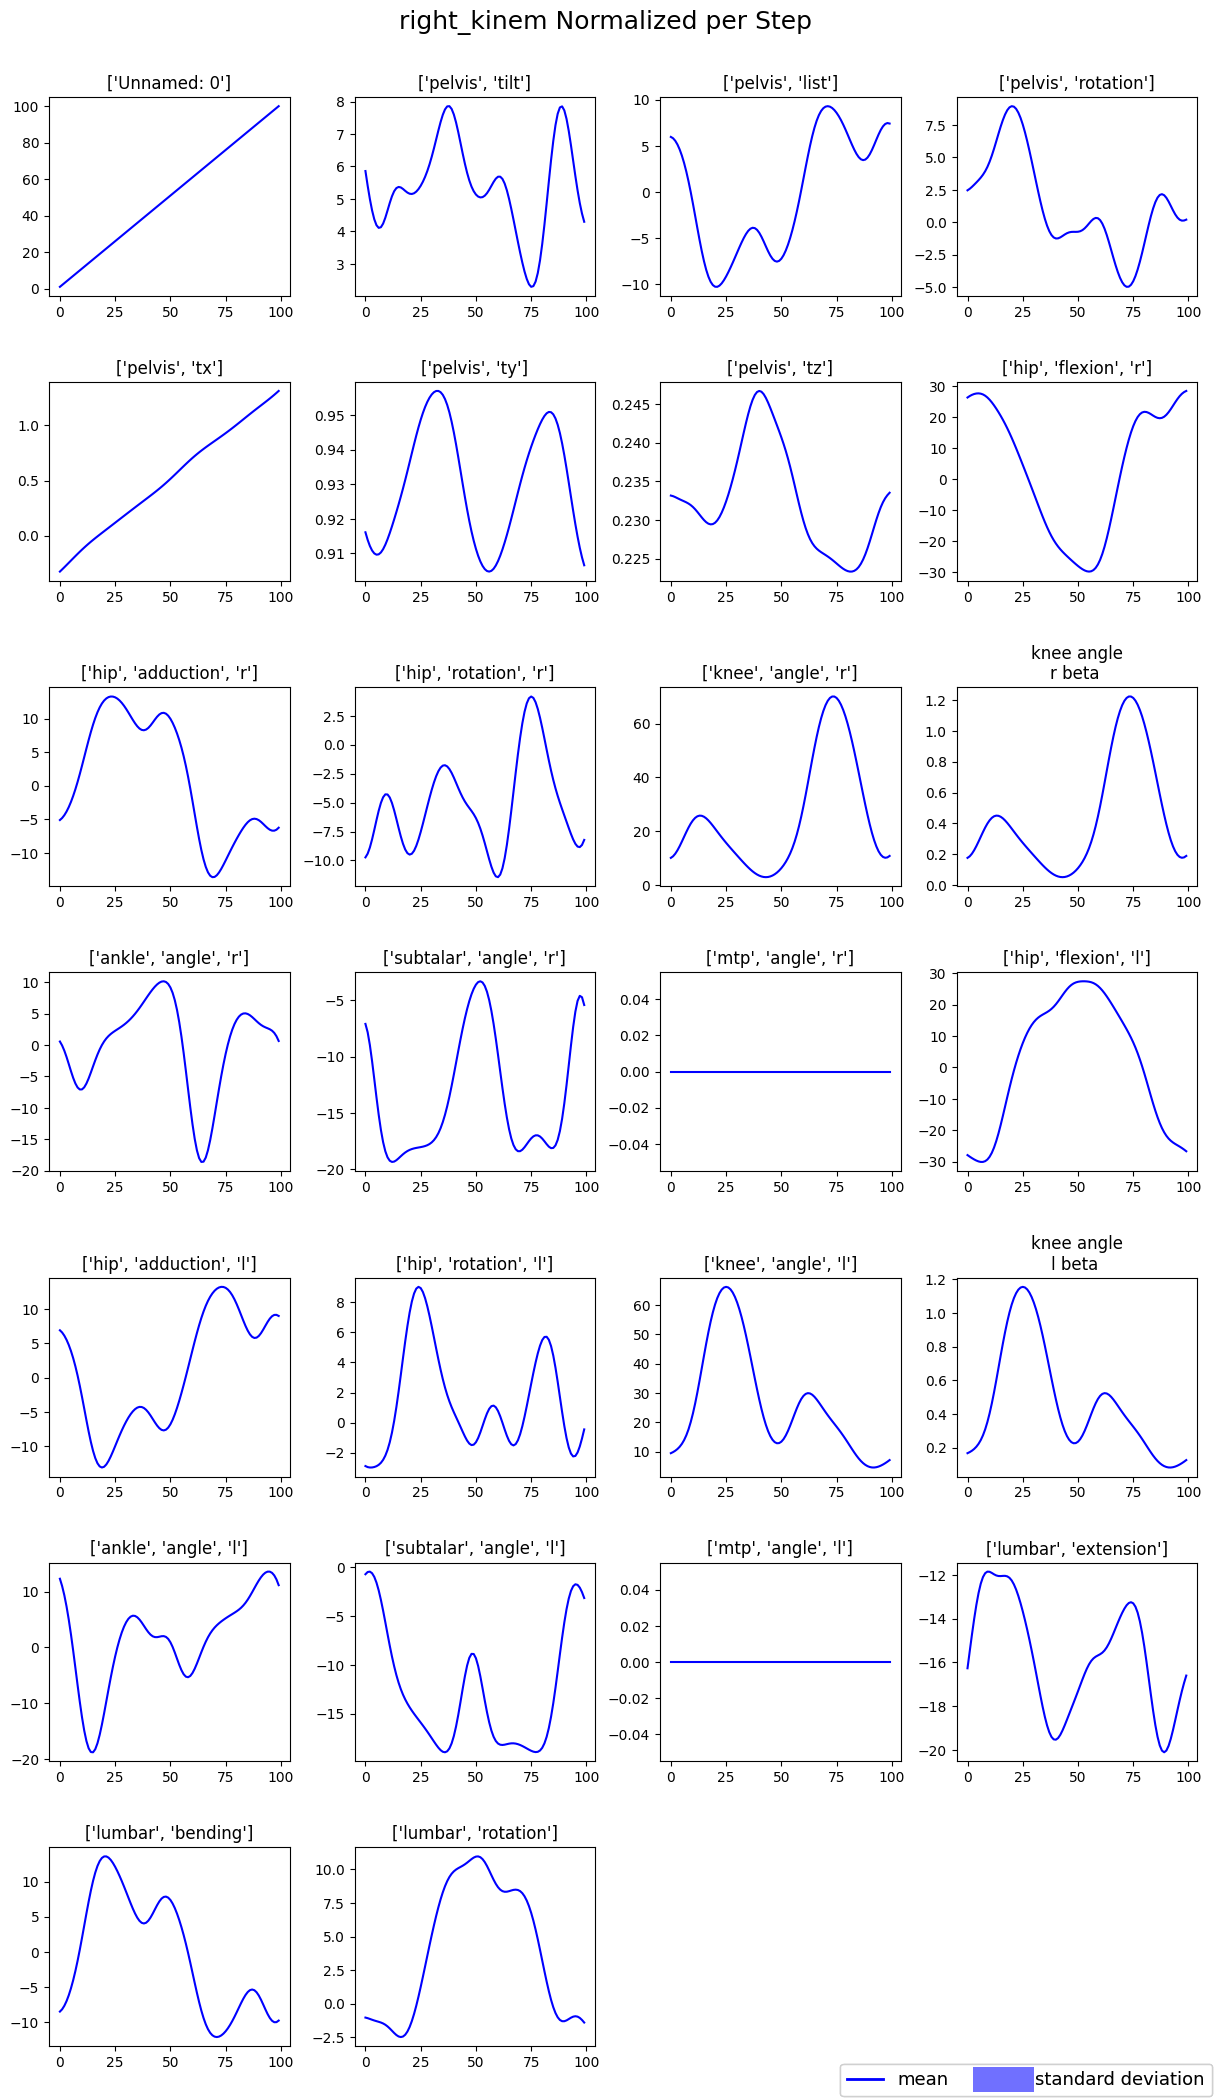

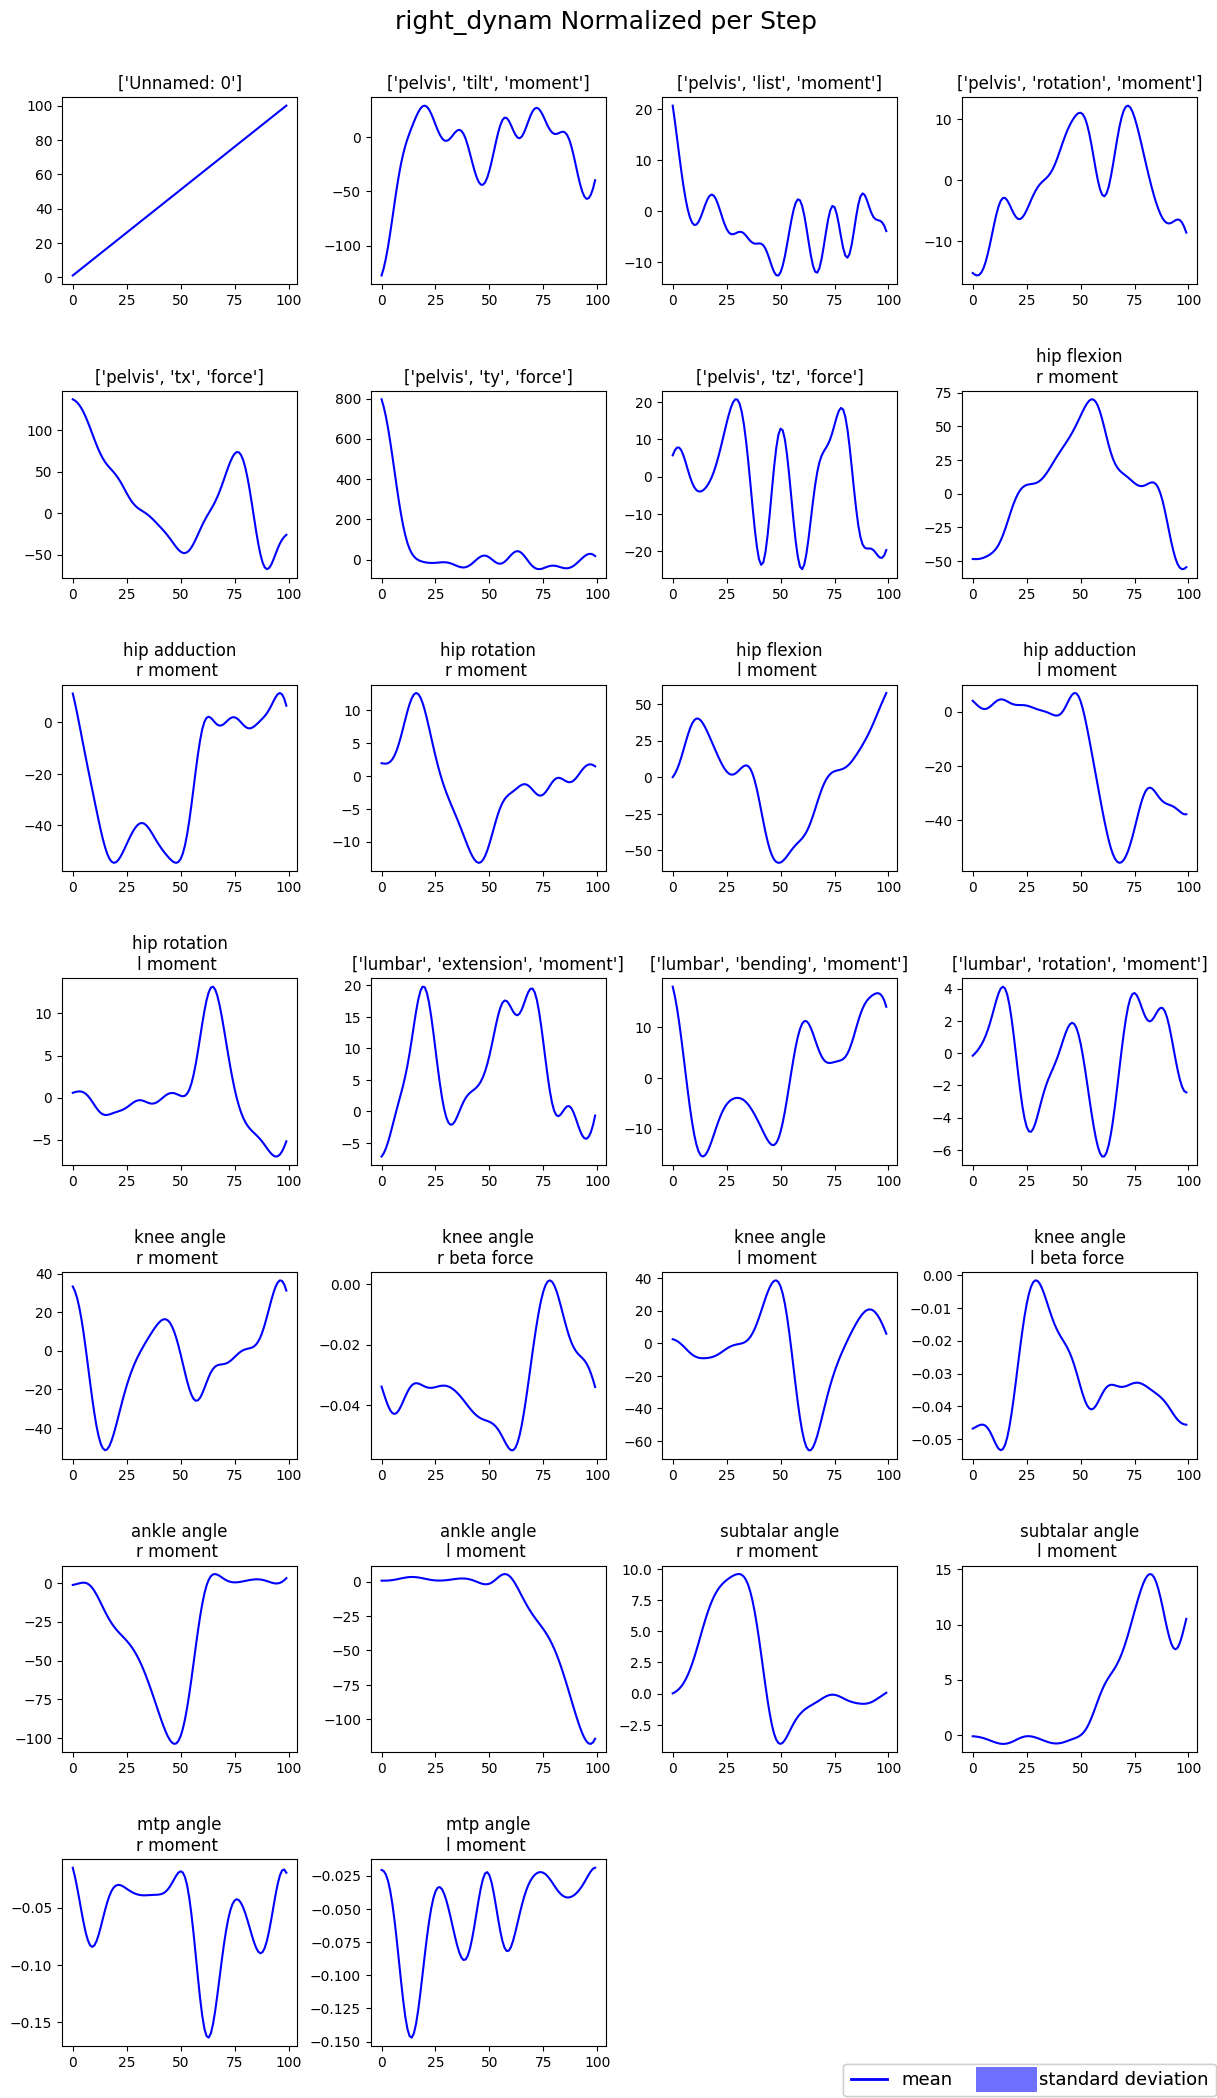

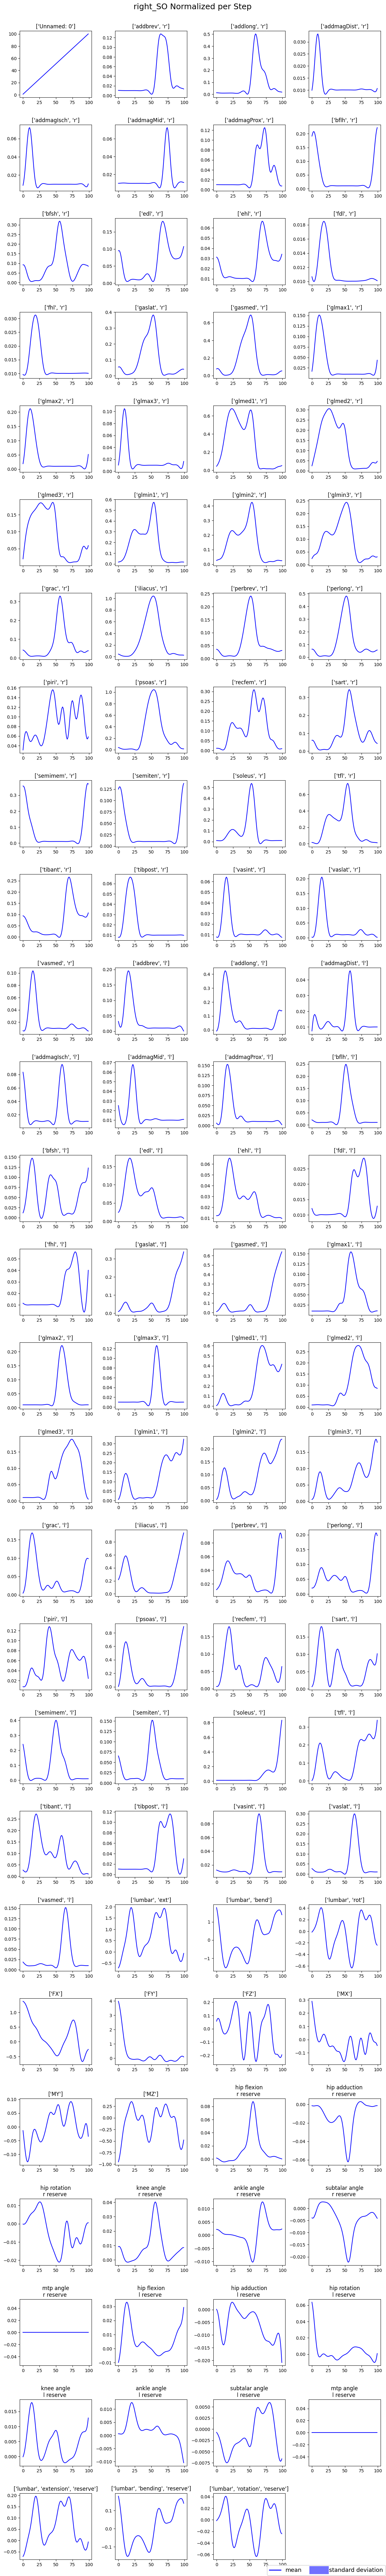

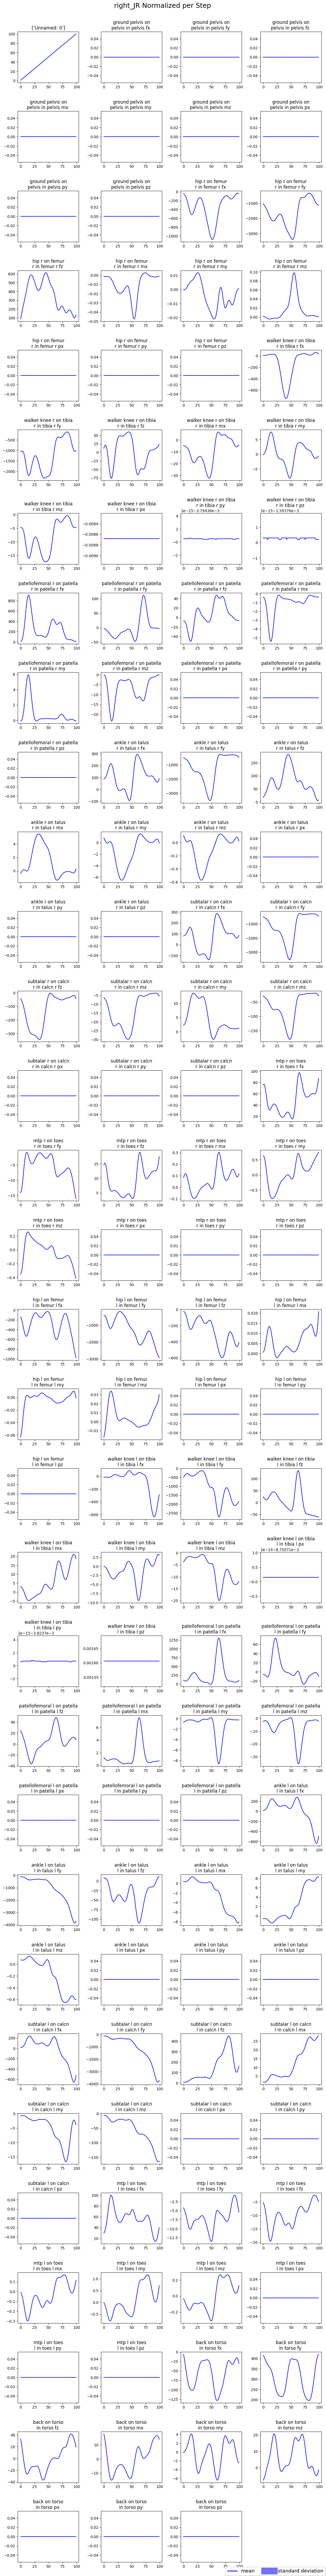

In [26]:
files_list = ['hip_rot_muscle_moment_arms.csv','hip_flex_muscle_moment_arms.csv',
 'hip_add_muscle_moment_arms.csv','knee_flex_muscle_moment_arms.csv',
 'ankle_flex_muscle_moment_arms.csv'] + ['kinem.csv', 'dynam.csv', 'SO.csv', 'JR.csv']

full_file_list = []
for name in files_list:
    for prefix in ['left_', 'right_']:
        full_file_list.append(prefix+name)


input_path = walking_results
output_path = os.path.abspath(os.path.join(walking_results, 'walking_results'))
if not os.path.exists(output_path):
    os.mkdir(output_path)   

compute_walking = ComputePersonalMeanAndSd(walking_dirs, full_file_list, input_path = input_path, output_path = output_path)
compute_walking.average_trials(plot = True)

## combine left and right plots

path_to_data = os.path.abspath(os.path.join(walking_results, 'walking_results'))
list_of_csv = []
allfiles = os.listdir(path_to_data)
for file in allfiles:
    if '.csv' in file:
        list_of_csv.append(file)

list_ma = []
for i, name in enumerate(list_of_csv):
    if '_muscle_moment_arms.csv'in name and 'means' in name and 'right' in name:
        list_ma.append(name)

%%capture out
for name in list_ma:
    plot_step_right_left(path_to_data, name)

list_f = []
for i, name in enumerate(list_of_csv):
    if not '_muscle_moment_arms.csv' in name and 'means' in name and 'right' in name:
        list_f.append(name)

%%capture out
for name in list_f:
    plot_step_right_left(path_to_data, name)

# Experiment

## Create new model with increased muscle force

model=osim.Model(os.path.join(model_folder, model_name))
muscles=model.getMuscles()
muscles.getSize()

good_muscles = []
for i in range(0, muscles.getSize()):
    currentMuscle = muscles.get(i)
    if currentMuscle.getName() not in good_muscles:
        forceScaleFactor = 2
        currentMuscle.setMaxIsometricForce(forceScaleFactor * currentMuscle.getMaxIsometricForce() )        
# pelvis_coordinates = model.getCoordinateSet().get('pelvis_tilt')
# pelvis_coordinates.setRangeMax(4)
# pelvis_coordinates.setRangeMin(-4)
model.printToXML(os.path.join(model_folder, f'{individual_tag}_tps_fibres_skin_wrp_force.osim'))
model_name =  f'{individual_tag}_tps_fibres_skin_wrp_force.osim'
run_walking_03 = RunAnalysesPipeline(individual_tag,model_name, model_folder,input_dir,
                                    trc_file_name, grf_mot_file_name, step_data_file_name,
                                    tempalte_dir, actuator_file)
run_walking_03.basic()
run_walking_03.run_so()